### Packages Required

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

### Data Manipulation

In [22]:
X = pd.read_csv("share_data.csv")
X.head()

,PERMNO,P0,P1,P2,P3,P4,P5,P6,P7,P8,...,P10,P11,P12,P13,P14,R0,R1,R2,R3,R4
0,10026,-0.000003,3.113666e-07,-1.237335e-06,-9.966010e-07,-2.366127e-06,5.351887e-07,-1.431051e-06,-8.510193e-07,2.980969e-06,...,2.154912e-06,-1.081326e-05,-0.000007,-0.000010,-6.001559e-07,-5.099129e-14,-1.208866e-11,-0.000314,0.001232,-0.000120
1,10032,-0.000003,-1.808966e-06,9.462290e-07,7.762409e-07,9.463456e-07,6.947888e-06,1.920773e-06,2.478089e-06,1.032153e-05,...,-7.024367e-06,-3.641545e-06,-0.000003,-0.000024,4.359397e-05,6.007102e-15,-4.354695e-12,-0.000138,0.000488,0.000248
2,10044,-0.000003,7.102607e-06,2.852410e-06,2.108310e-06,2.228871e-06,-3.546014e-06,1.241538e-06,-2.072489e-05,6.031887e-07,...,2.207878e-07,-2.928287e-08,-0.000014,-0.000022,-6.040083e-06,-1.932483e-14,-4.926170e-12,-0.000184,0.000665,0.000069
3,10104,-0.000002,-2.424858e-06,4.217685e-07,-1.290801e-06,2.586486e-07,3.930600e-06,-1.913988e-07,-1.899509e-06,-6.181321e-06,...,-8.403849e-06,-7.685632e-06,-0.000004,-0.000013,-6.965857e-07,9.639787e-15,-5.020164e-12,-0.000173,0.000657,0.000270
4,10107,-0.000003,3.273500e-06,-4.078461e-06,-2.239714e-06,8.094752e-06,6.239436e-07,1.357327e-06,-1.374500e-06,6.426802e-06,...,4.068869e-07,1.249042e-05,-0.000002,-0.000004,9.768741e-07,-4.131016e-14,-1.353126e-11,-0.000366,0.001423,0.000189


In [23]:
X = X.set_index("PERMNO")

In [24]:
train_data = preprocessing.StandardScaler().fit_transform(X)
print(train_data.shape)

(1782, 20)


### DBSCAN Alogrithm

In [25]:
clf = DBSCAN(eps=1, min_samples = 2)
print(clf)

DBSCAN(eps=1, min_samples=2)


In [26]:
clf.fit(train_data)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Clusters discovered: %d" % n_clusters_)

Clusters discovered: 12


In [27]:
clustered = clf.labels_
clustered_series = pd.Series(index = X.index, data = clustered.flatten())
clustered_series_all = pd.Series(index = X.index, data = clustered.flatten())
# clustered_series = clustered_series[clustered_series != 1]

In [28]:
clustered_series.name = 'label'
joined = pd.DataFrame(train_data, columns=X.columns, index= X.index)
clus = joined.loc[clustered_series[clustered_series!=-1].index]
clus = clus.join(clustered_series)


### Evaluation

In [29]:
def davies_bouldin_index(X, labels):
    n_clusters = len(set(labels))
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
    scatter = np.array([np.mean(pairwise_distances(X[labels == i], [centroid])) for i, centroid in enumerate(centroids)])
    centroid_distances = pairwise_distances(centroids)
    dbi = 0.0
    for i in range(n_clusters):
        max_ratio = -np.inf
        for j in range(n_clusters):
            if i != j:
                # Calculate the ratio of within-cluster scatter to between-cluster distance
                ratio = (scatter[i] + scatter[j]) / centroid_distances[i][j]
                max_ratio = max(max_ratio, ratio)
        dbi += max_ratio

    dbi /= n_clusters
    return dbi

metric_check = clustered_series.reset_index()
silhouette_avg = silhouette_score(clus.drop(columns=['label']), clus['label'])
print("Silhouette Score:", silhouette_avg)
 
distances = pairwise_distances(clus.drop(columns=['label']), clf.components_, metric='euclidean')
max_distances = np.max(distances, axis=1)
distortion = np.mean(max_distances ** 2)
print("Distortion Score:", distortion)

print("Davies Bouldin Index:", davies_bouldin_index(clus.drop(columns=['label']), clus['label']))


Silhouette Score: 0.5298672558951364


Distortion Score: 133.16448850063605
Davies Bouldin Index: 0.738242314587927


In [30]:
cluster_size_limit = 100
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts > 1) & (counts <= cluster_size_limit)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 11
Pairs to evaluate: 2470


### Results

In [31]:
#plot multidimension to 2d
X_tsne = TSNE(learning_rate = 1000, perplexity = 25, random_state = 1337).fit_transform(X)

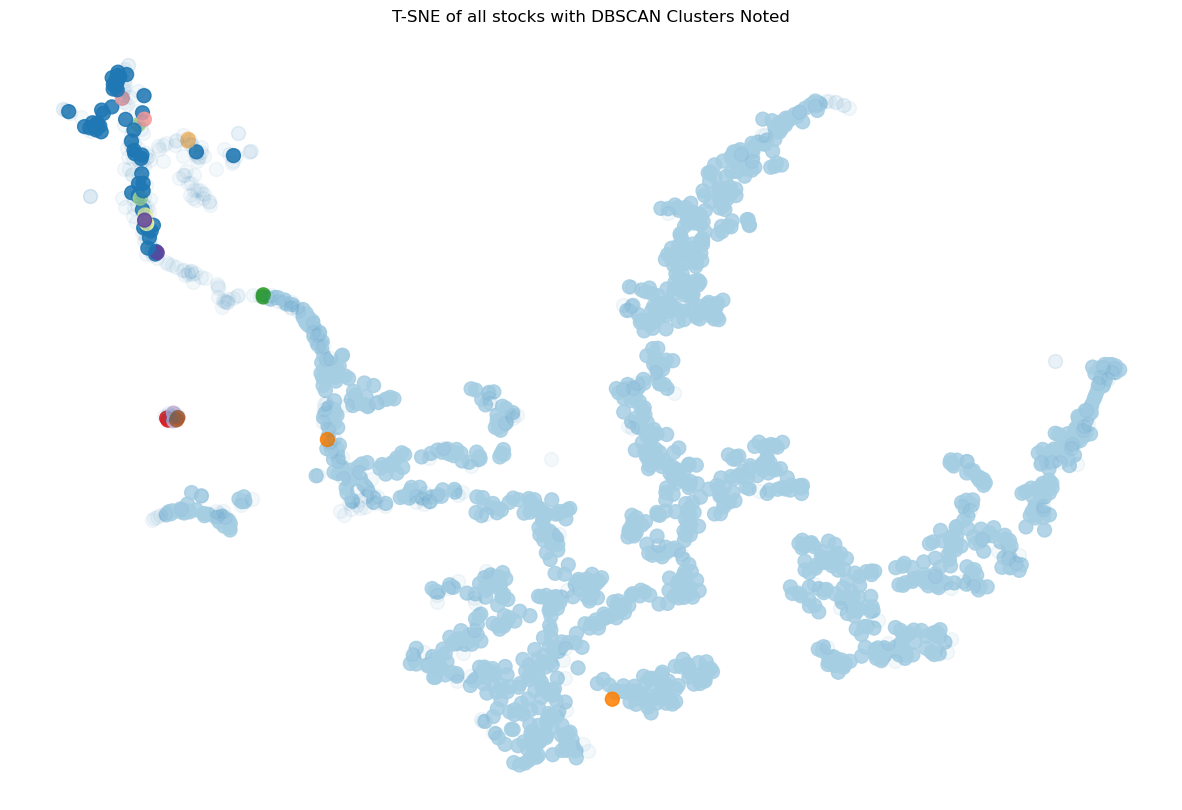

In [32]:
plt.figure(1, facecolor = 'white', figsize = (15, 10))
plt.clf()
plt.axis('off')

plt.scatter(X_tsne[(labels!=-1), 0], X_tsne[(labels!=-1), 1], s = 100, alpha = 0.85, c = labels[labels!=-1], cmap = cm.Paired)
plt.scatter(X_tsne[(clustered_series_all==-1).values, 0], X_tsne[(clustered_series_all==-1).values, 1], s = 100, alpha = 0.05)
plt.title('T-SNE of all stocks with DBSCAN Clusters Noted')
plt.savefig('Pictures/T-SNE_plot_for_stock_clusters.png')
plt.show()

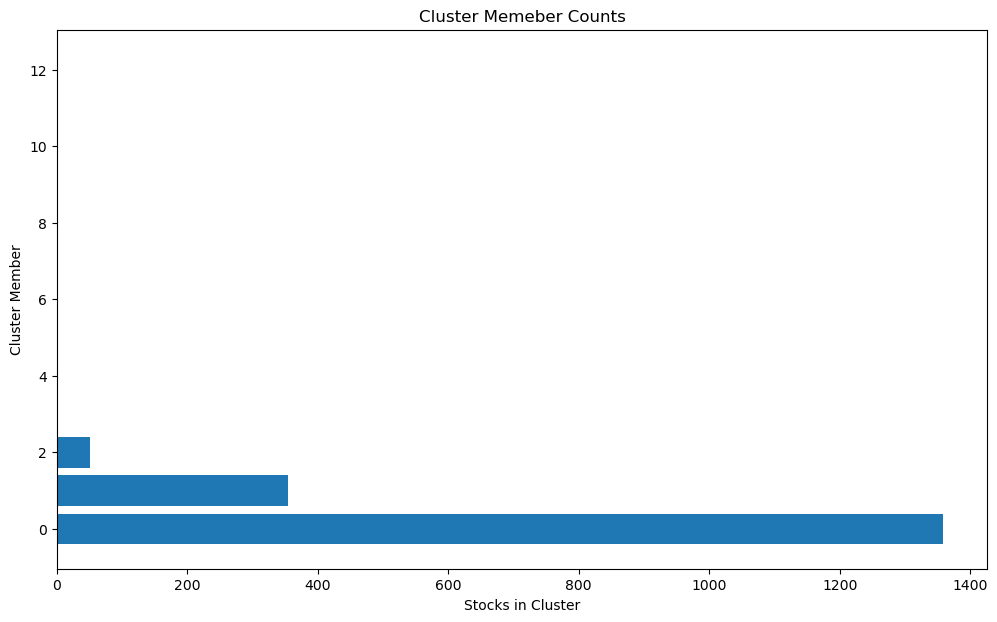

In [33]:
plt.figure(figsize = (12, 7))
plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Cluster Memeber Counts")
plt.xlabel('Stocks in Cluster')
plt.ylabel("Cluster Member")
plt.savefig('Pictures/cluster_member_counts.png')
plt.show()

In [34]:
counts = clustered_series.value_counts()
clusters_viz_list = list(counts[(counts < 500) & (counts > 1)].index)[::-1]
print(clusters_viz_list)

[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, -1]


In [35]:
price_df = pd.read_csv("stock_price_table.csv")

In [36]:
stock_price = price_df.set_index("PERMNO")

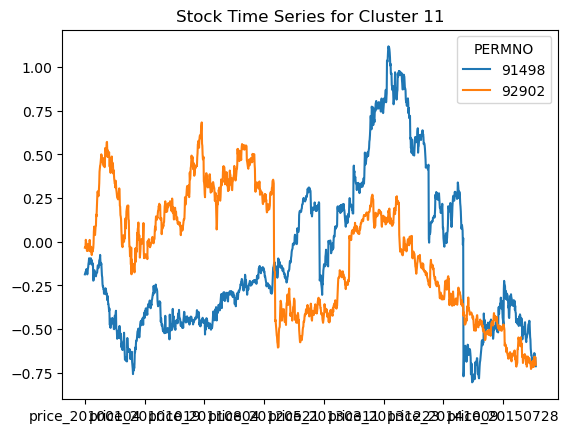

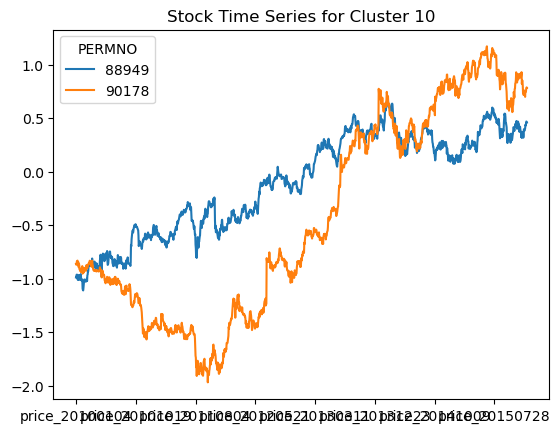

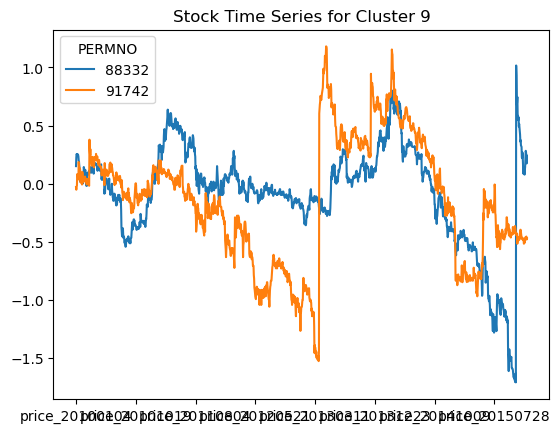

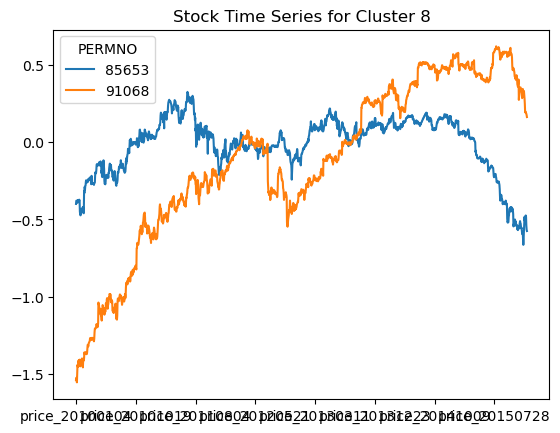

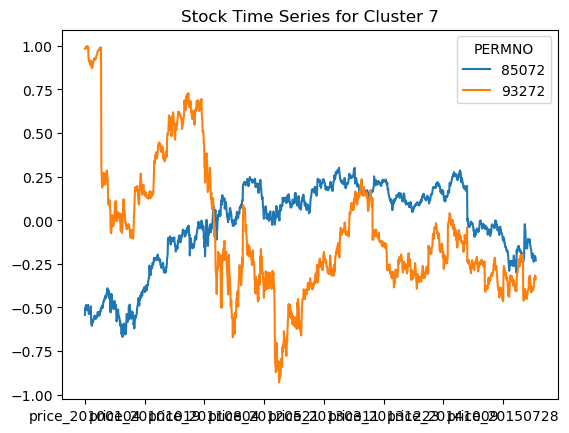

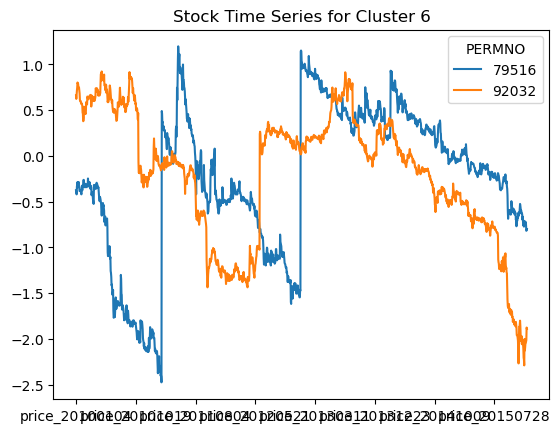

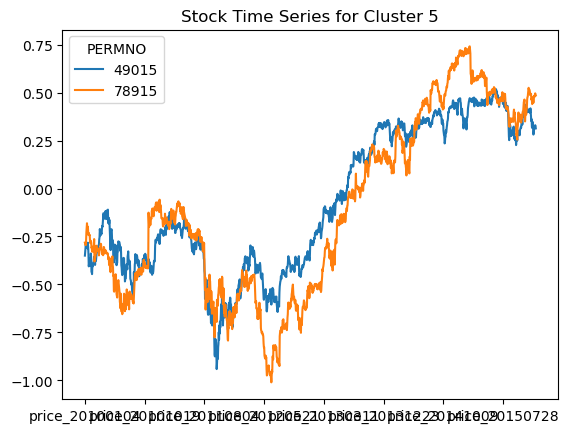

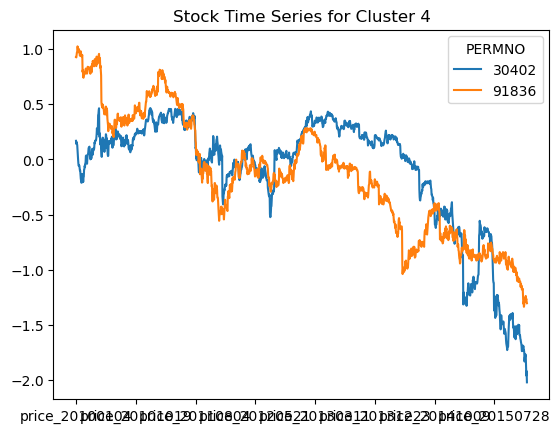

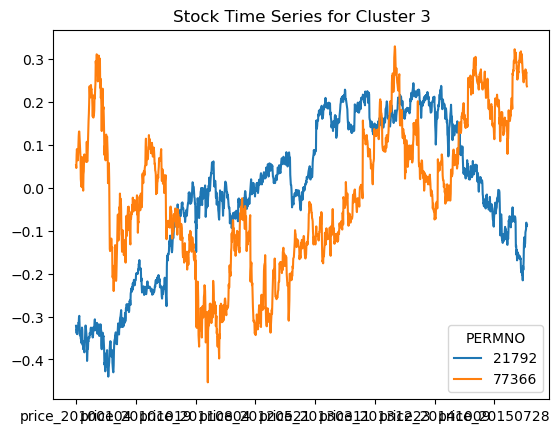

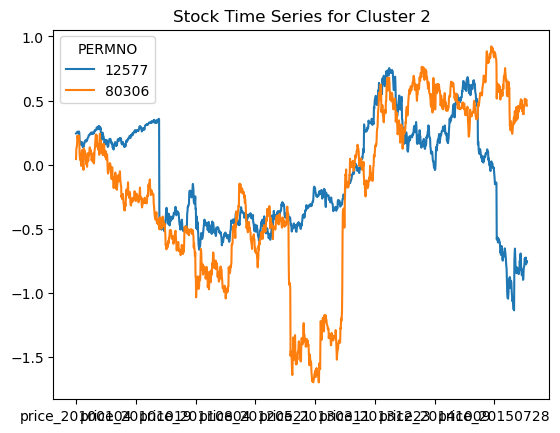

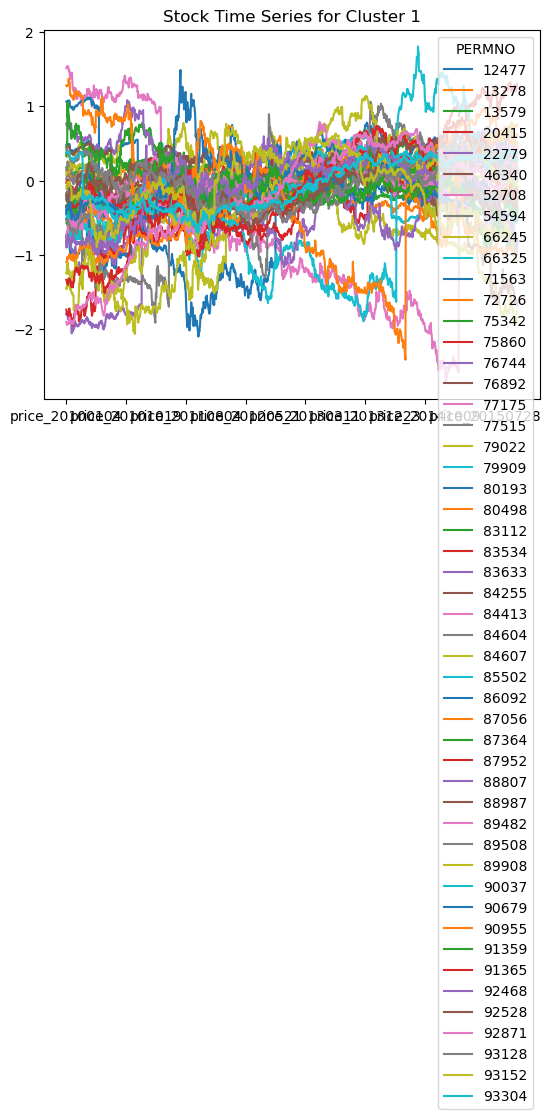

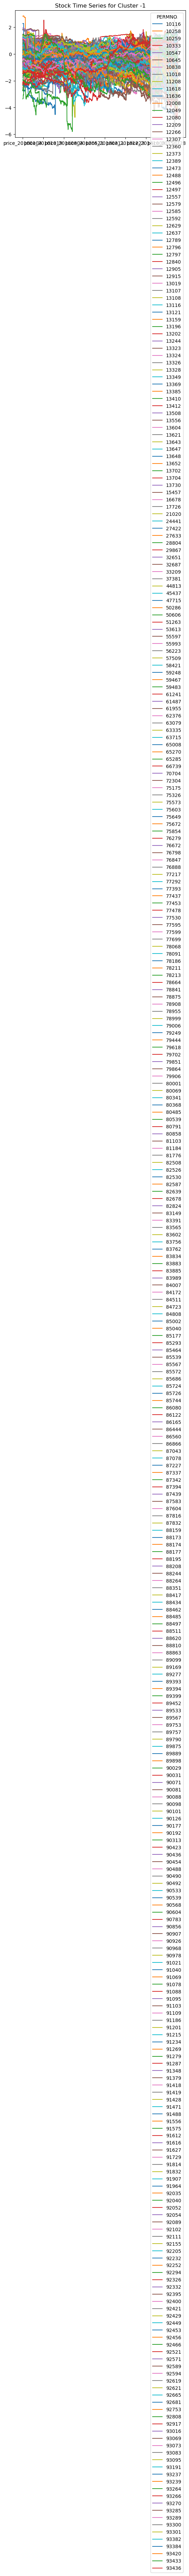

In [37]:
for c in clusters_viz_list:
    stocks = list(clustered_series[clustered_series==c].index)
    means = np.log(stock_price.loc[stocks,].T.mean())
    data = np.log(stock_price.loc[stocks,]).T.sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % c)
    plt.savefig('Pictures/stock_price_clsuter_'+str(c)+'.png')
    plt.show()

### Cointegration

In [62]:
def Cointegration(cluster, significance, start_day, end_day, Price):
    pair_coin = []
    p_value = []
    n = cluster.shape[0]
    keys = cluster.keys()
    for i in range(n):
        for j in range(i+1,n):
            asset_1 = Price.loc[keys[i], start_day:end_day]
            asset_2 = Price.loc[keys[j], start_day:end_day]
            results = sm.OLS(asset_1, asset_2).fit()
            predict = results.predict(asset_2)
            error = asset_1 - predict
            ADFtest = ts.adfuller(error)
            if ADFtest[1] < significance:
                pair_coin.append([keys[i], keys[j]])
                p_value.append(ADFtest[1])
    return p_value, pair_coin

In [76]:
import heapq
import operator
def PairSelection(clustered_series, significance, start_day, end_day, Price, E_selection = False):
    Opt_pairs = []   # to get best pair in cluster i
    
    if E_selection == True: # select one pair from each cluster
        for i in clusters_viz_list:
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day, Price)
            if len(result[0]) > 0:
                if np.min(result[0]) < significance:
                    index = np.where(result[0] == np.min(result[0]))[0][0]
                    Opt_pairs.append([result[1][index][0], result[1][index][1]]) 
    else:
        p_value_contval = []
        pairs_contval = []
        for i in clusters_viz_list:
            if(i>=1):
                print(i)
                cluster = clustered_series[clustered_series == i]
                keys = cluster.keys()
                result = Cointegration(cluster, significance, start_day, end_day, Price)
                if len(result[0]) > 0:
                    p_value_contval += result[0]
                    pairs_contval += result[1]
        
        Opt_pair_index = heapq.nsmallest(20, range(len(p_value_contval)), key=p_value_contval.__getitem__)
        print(Opt_pair_index)
        Opt_pairs = operator.itemgetter(*Opt_pair_index)(pairs_contval)
    return Opt_pairs

In [54]:
significance = 0.05
start_date = '20100104'
end_date = "20151231"

stock_price = pd.read_csv("stock_price_table.csv", index_col = 0)
stock_price.columns = stock_price.columns.str.lstrip('price_')


In [77]:
opt_pairs = PairSelection(clustered_series, significance, start_date, end_date, stock_price)

11
10
9
8
7
6
5
4
3
2
1
[164, 168, 106, 125, 54, 136, 28, 172, 12, 17, 30, 8, 176, 14, 75, 130, 162, 4, 139, 88]


In [78]:
lookup_table = pd.read_csv("crsp_dataset.csv")[['PERMNO','Ticker']].drop_duplicates()
lookup_table.head()

,PERMNO,Ticker
0,10001,EGAS
1910,10001,NaN
1911,10002,BTFG
2697,10002,NaN
2698,10025,AEPI


In [79]:
#preview of cointegrated pairs
def plot_pairs(asset1, asset2, start_date, end_date, df_price, lookup_table):
    
    price1 = df_price.loc[asset1, start_date:end_date]
    price2 = df_price.loc[asset2, start_date:end_date]
    
    tic1 = lookup_table.loc[lookup_table['PERMNO'] == asset1, 'Ticker'].values[0]
    tic2 = lookup_table.loc[lookup_table['PERMNO'] == asset2, 'Ticker'].values[0]
    
    fig = plt.figure(figsize = (10,7))
    ax = fig.add_subplot(111)

    ax.set_xlabel(tic1)
    ax.set_ylabel(tic2)
    
    ax.scatter(price1[100:252], price2[100:252], color = 'b', label = 'year 2010')
    ax.scatter(price1[252:504], price2[252:504], color = 'g', label = 'year 2011')
    ax.scatter(price1[504:756], price2[504:756], color = 'r', label = 'year 2012')
    ax.scatter(price1[756:1008], price2[756:1008], color = 'c', label = 'year 2013')
    ax.scatter(price1[1008:1260], price2[1008:1260], color = 'm', label = 'year 2014')
    ax.scatter(price1[1260:], price2[1260:], color = 'k', label = 'year 2015')
    
    ax.legend()
    plt.savefig("Pictures/"+str(tic1)+'_'+str(tic2)+'.png')
    plt.show()

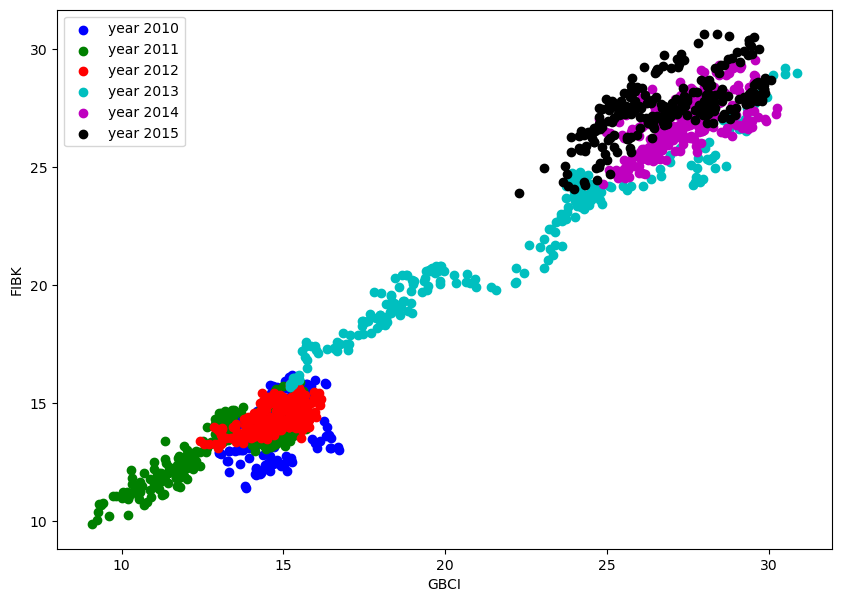

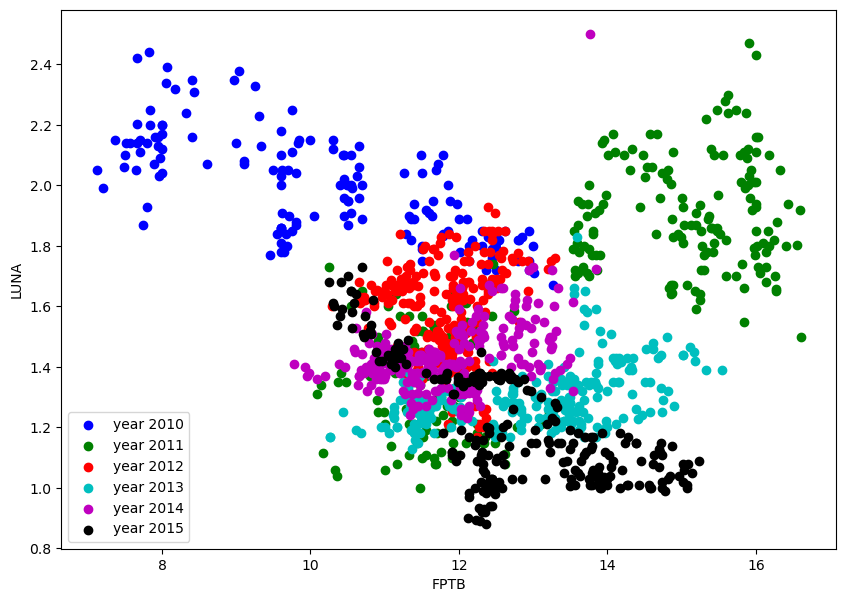

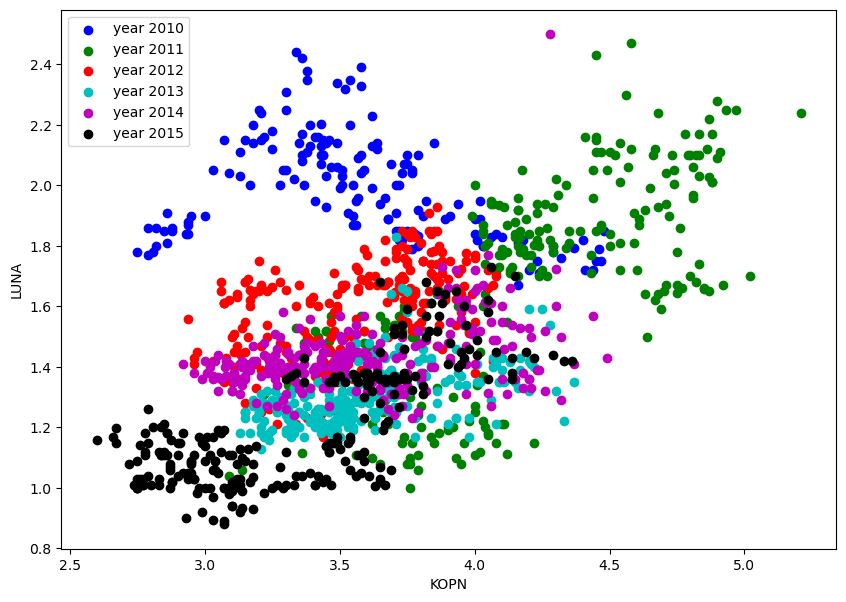

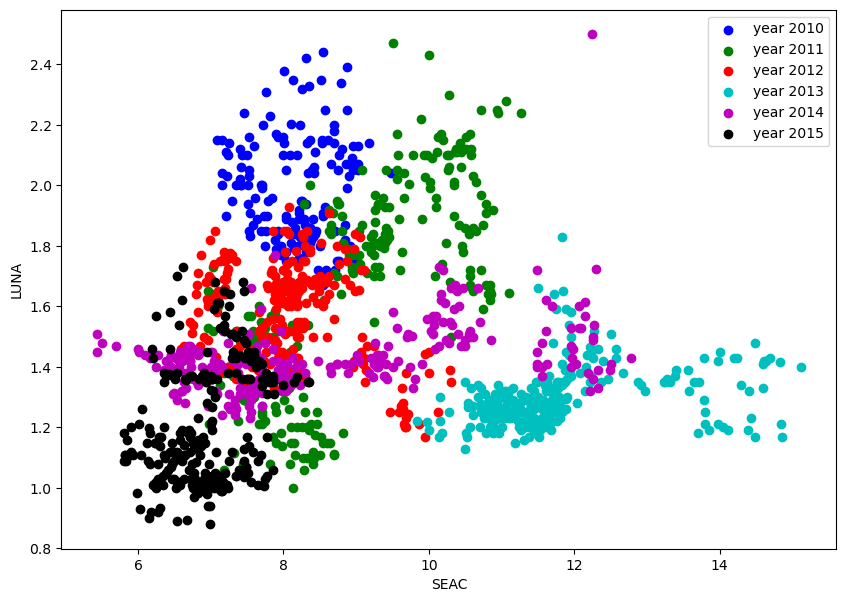

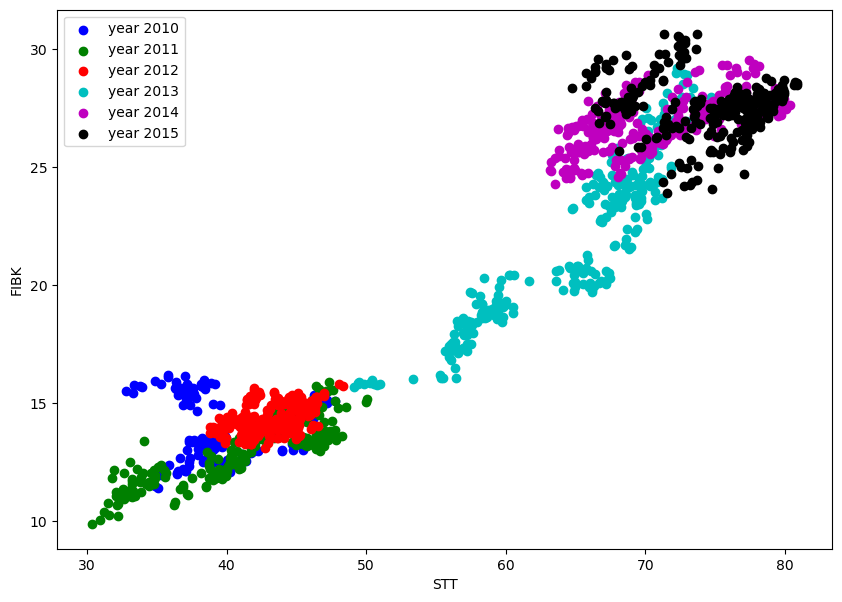

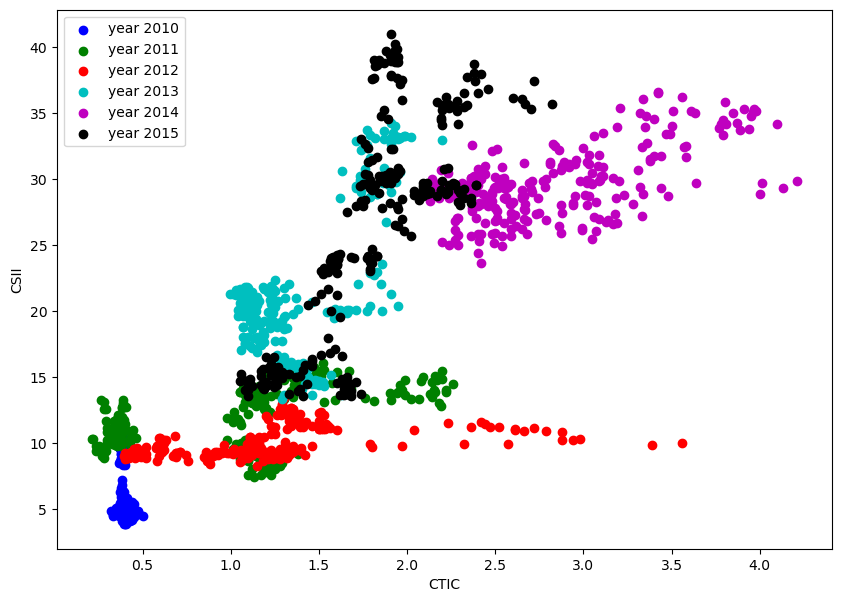

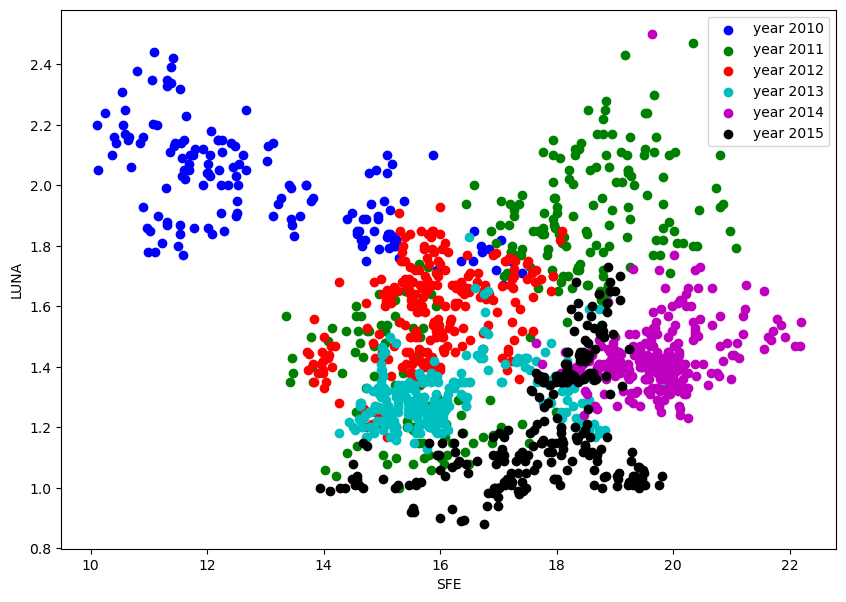

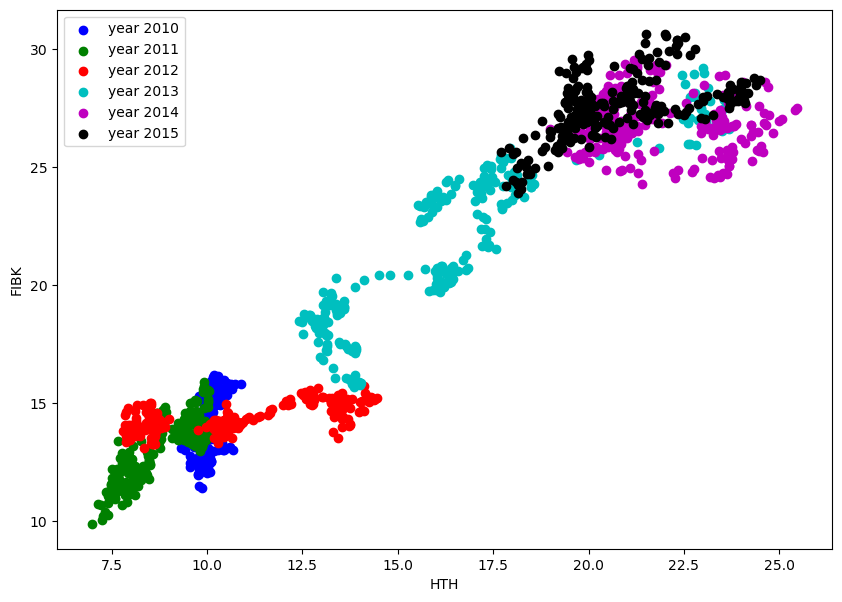

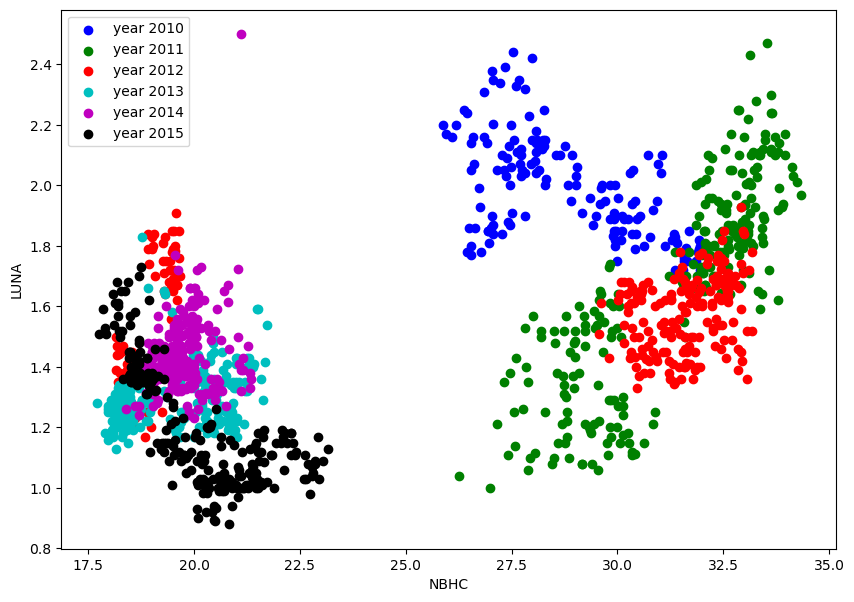

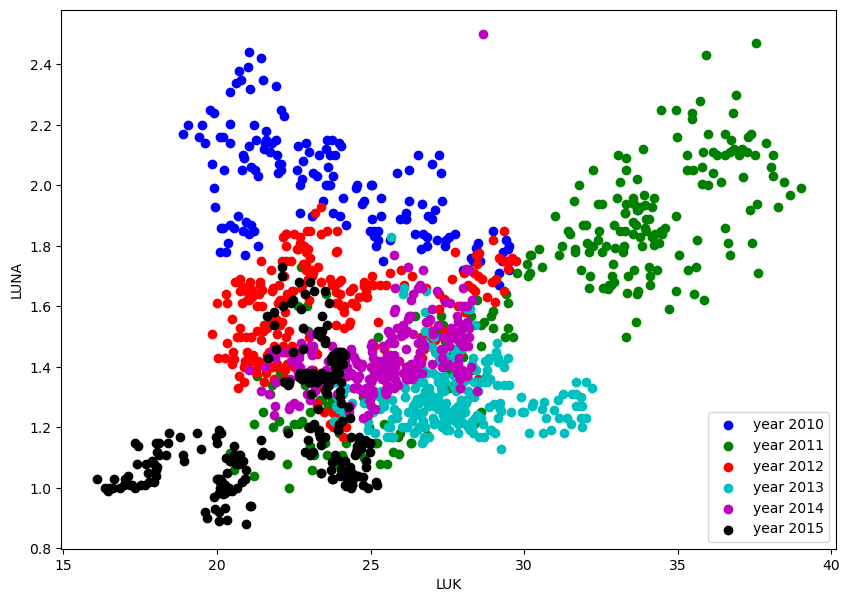

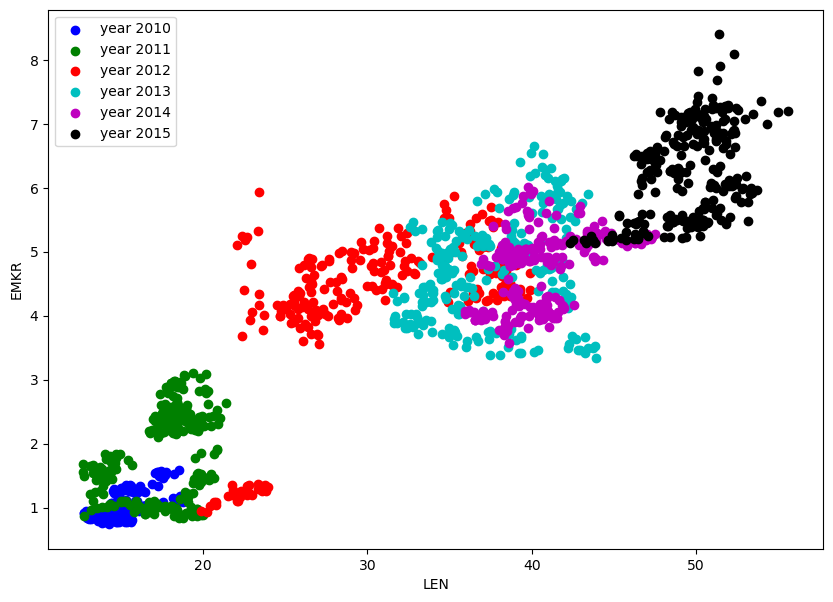

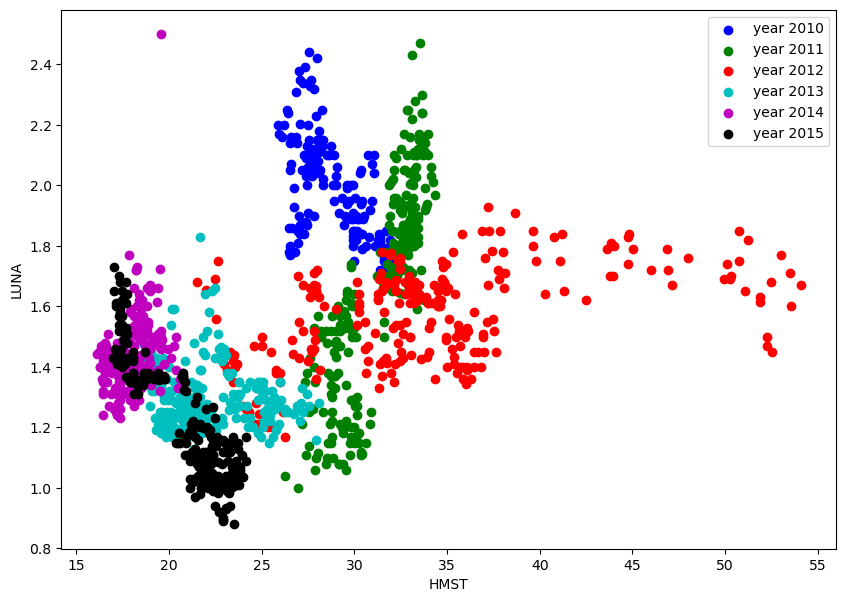

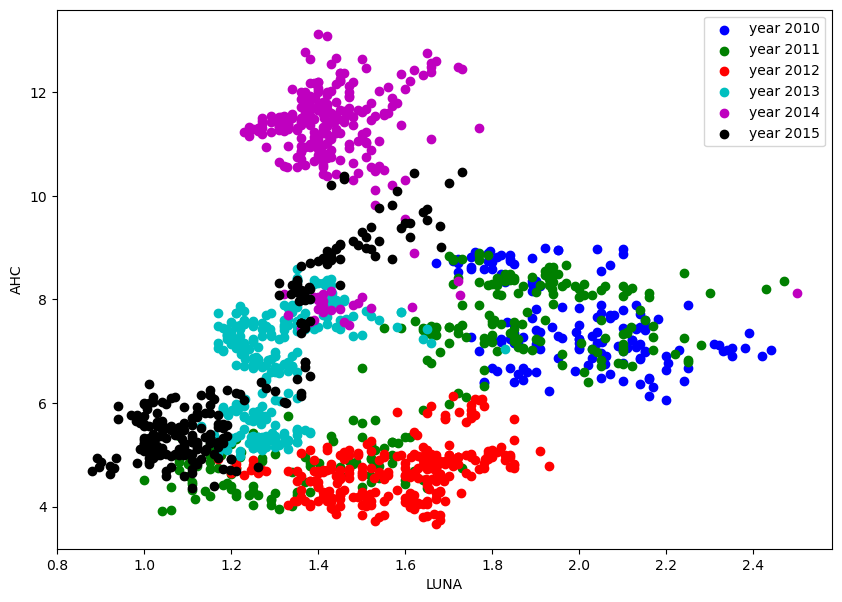

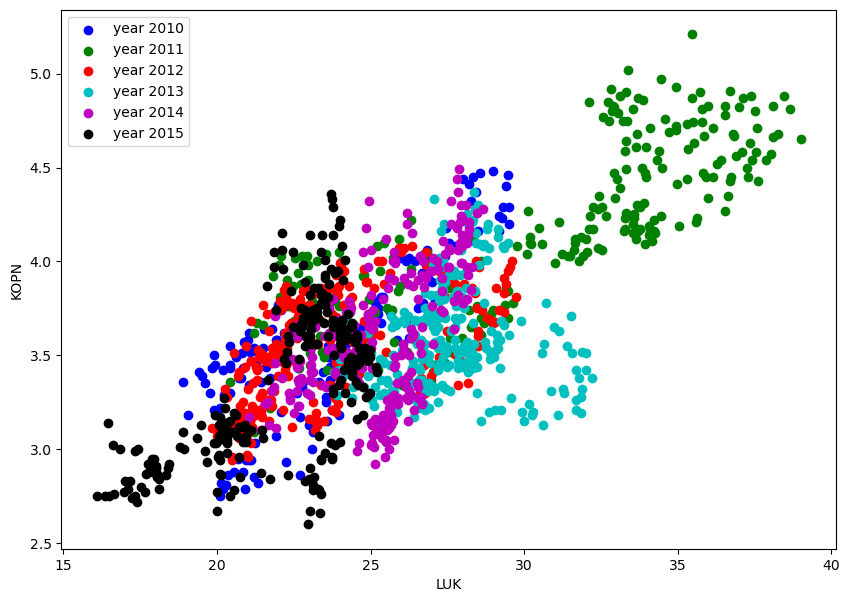

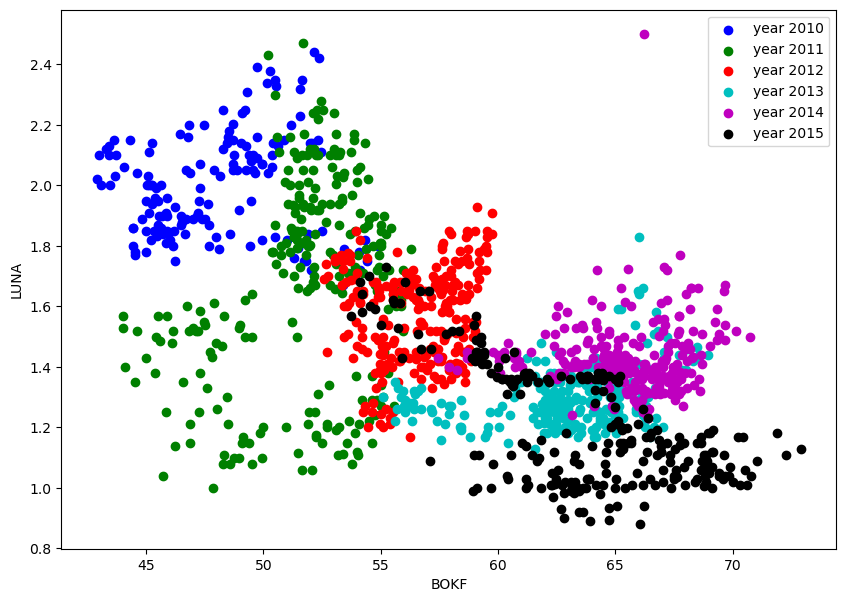

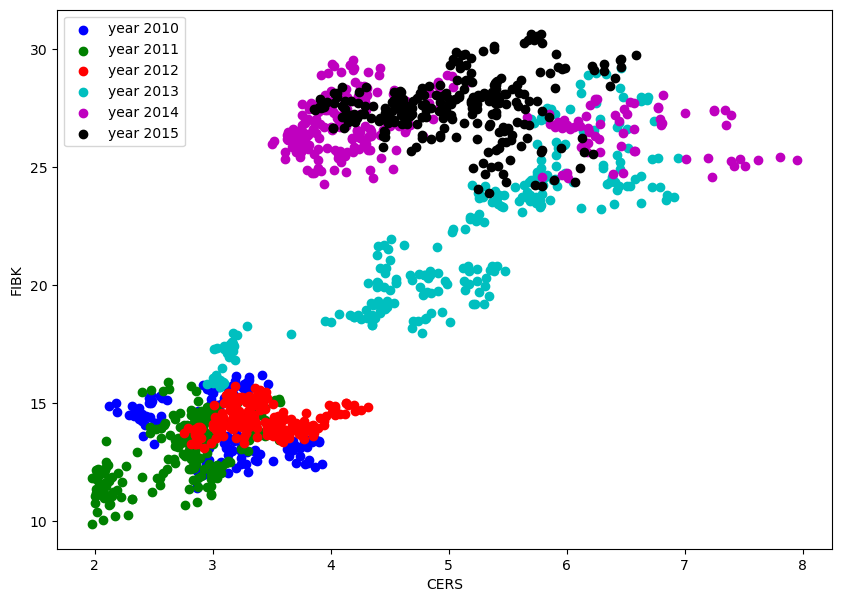

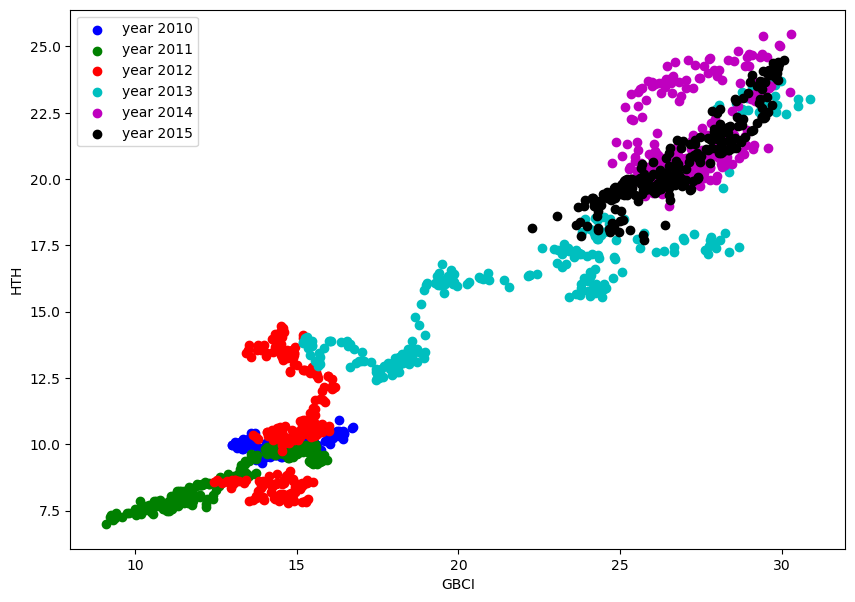

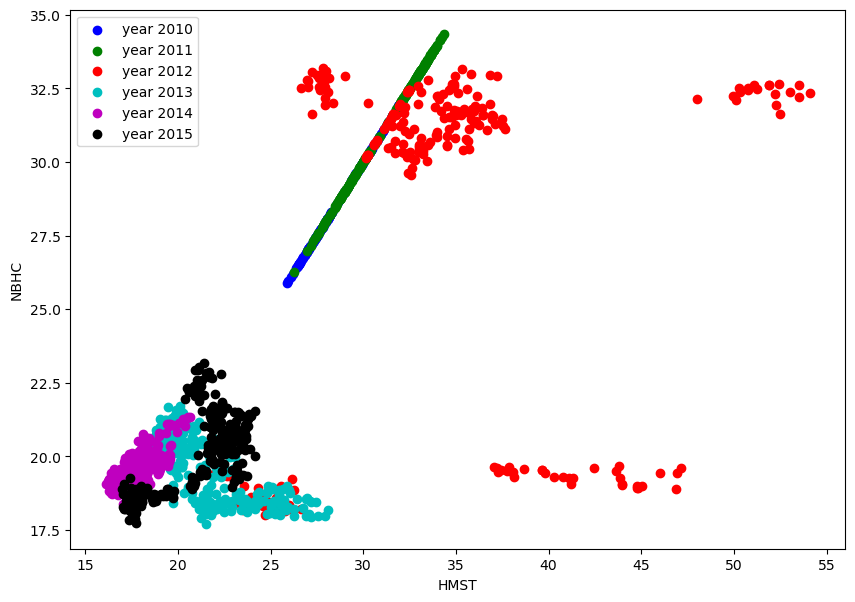

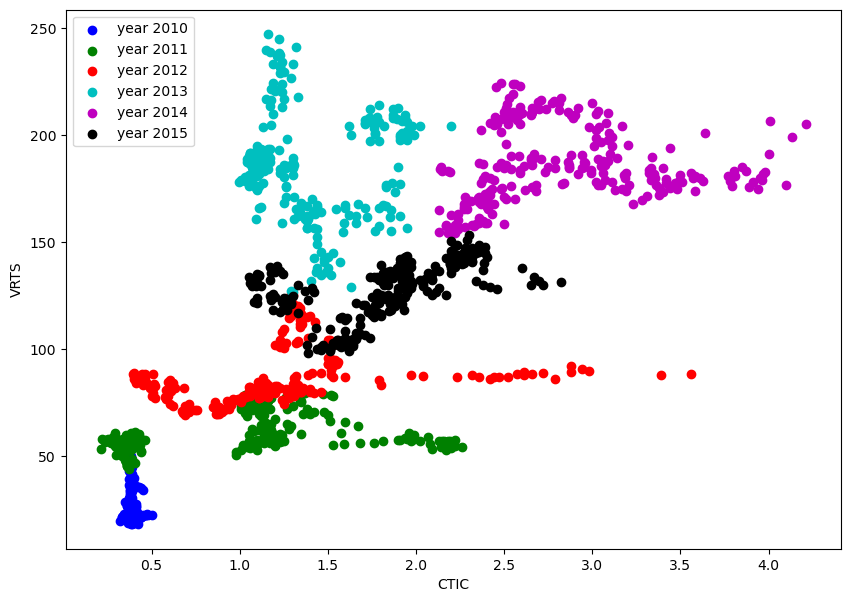

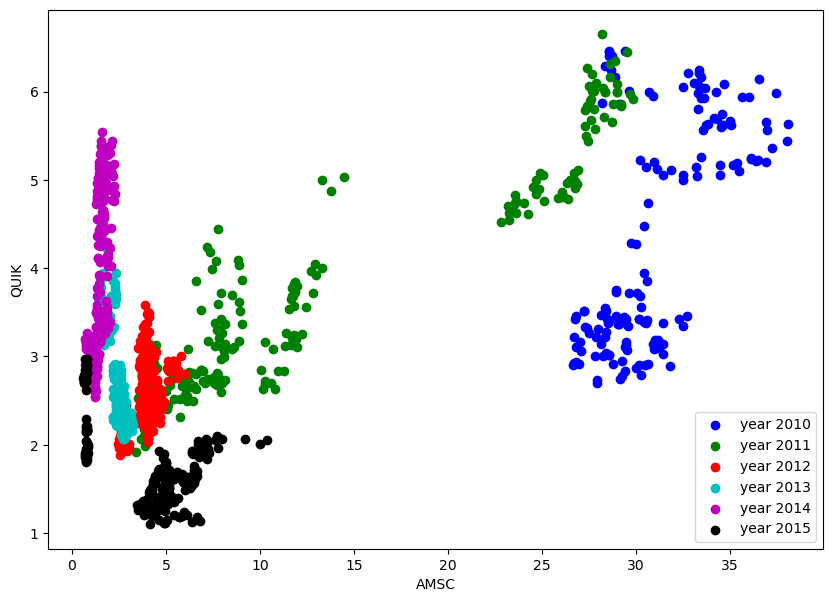

In [80]:
start_date = '20100101'
end_date = '20151231'
for pair in opt_pairs:
    asset1 = pair[0]
    asset2 = pair[1]
    plot_pairs(asset1, asset2, start_date, end_date, stock_price, lookup_table)